Depot opening hours: 0h00-20h36
Total distance: 2041
Number of routes: 18

Route 1: [0, 20, 21, 22, 23, 26, 28, 27, 24, 0]
Truck capacity: 110.0
Total distance travelled: 43
Starting time: 0h19
Ending time: 20h08



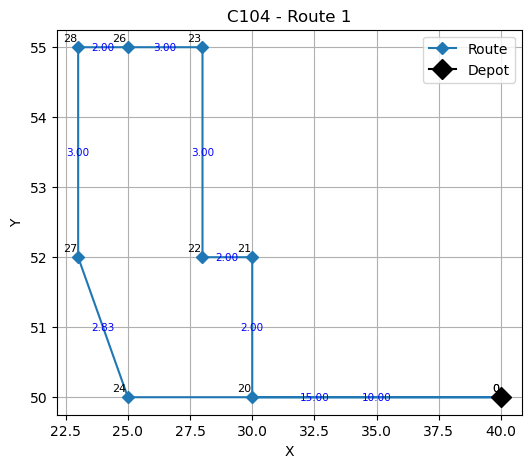

Route 2: [0, 67, 65, 63, 62, 66, 69, 68, 64, 0]
Truck capacity: 130.0
Total distance travelled: 55
Starting time: 0h19
Ending time: 20h16



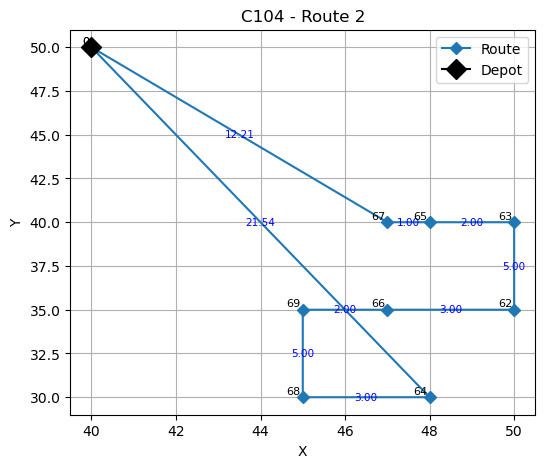

Route 3: [0, 5, 3, 4, 6, 7, 10, 75, 0]
Truck capacity: 100.0
Total distance travelled: 55
Starting time: 0h19
Ending time: 20h13



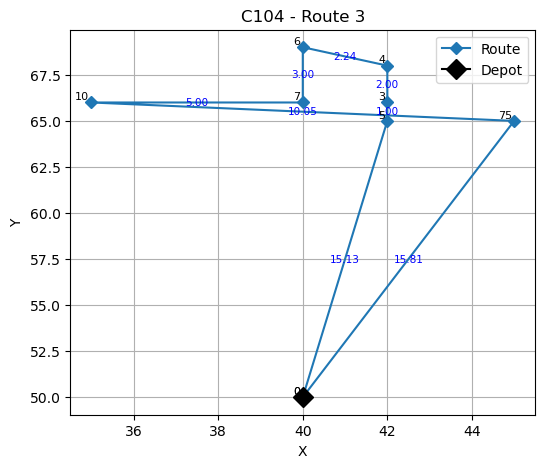

Route 4: [0, 25, 29, 30, 34, 36, 39, 37, 35, 31, 32, 0]
Truck capacity: 190.0
Total distance travelled: 102
Starting time: 0h19
Ending time: 19h16



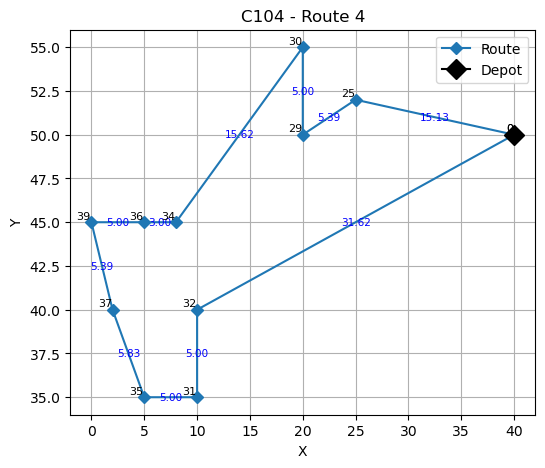

Route 5: [0, 43, 42, 41, 40, 44, 45, 46, 48, 50, 51, 52, 49, 0]
Truck capacity: 150.0
Total distance travelled: 66
Starting time: 0h19
Ending time: 19h24



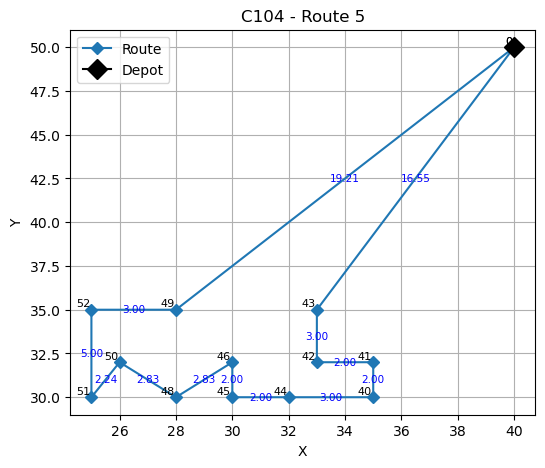

Route 6: [0, 47, 61, 72, 74, 90, 89, 88, 85, 86, 83, 82, 0]
Truck capacity: 200.0
Total distance travelled: 128
Starting time: 0h19
Ending time: 19h14



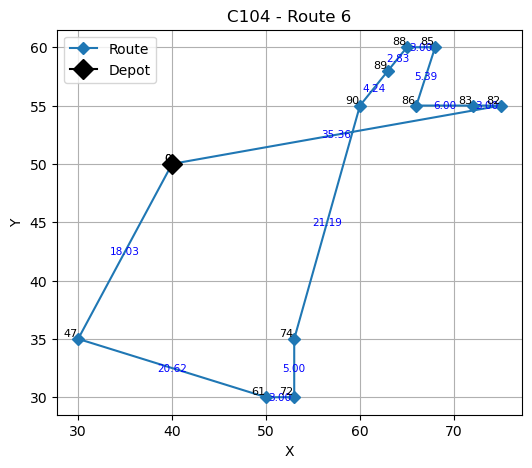

Route 7: [0, 8, 9, 2, 1, 98, 96, 95, 0]
Truck capacity: 130.0
Total distance travelled: 89
Starting time: 0h19
Ending time: 19h02



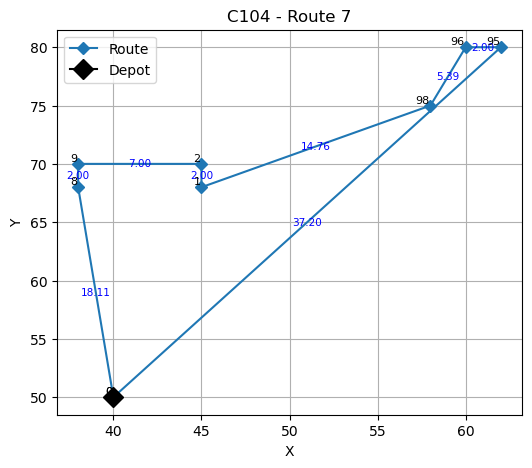

Route 8: [0, 11, 17, 18, 19, 16, 14, 12, 0]
Truck capacity: 130.0
Total distance travelled: 96
Starting time: 7h28
Ending time: 19h34



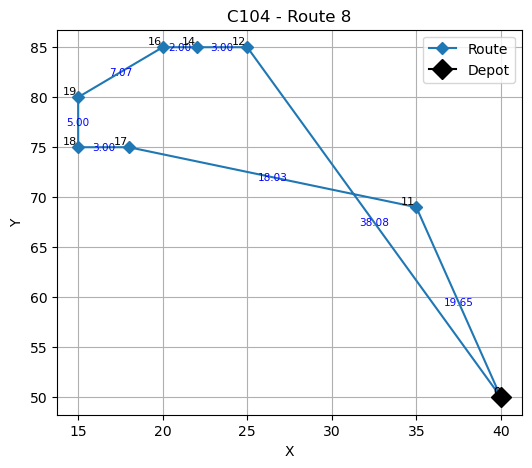

Route 9: [0, 91, 84, 94, 93, 97, 81, 78, 0]
Truck capacity: 160.0
Total distance travelled: 175
Starting time: 0h31
Ending time: 19h00



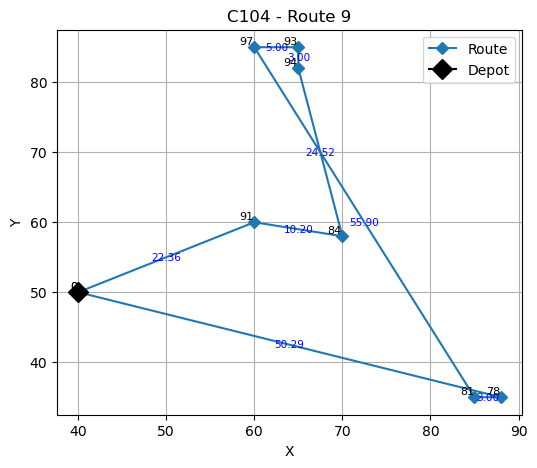

Route 10: [0, 87, 99, 71, 70, 73, 0]
Truck capacity: 90.0
Total distance travelled: 177
Starting time: 0h31
Ending time: 20h27



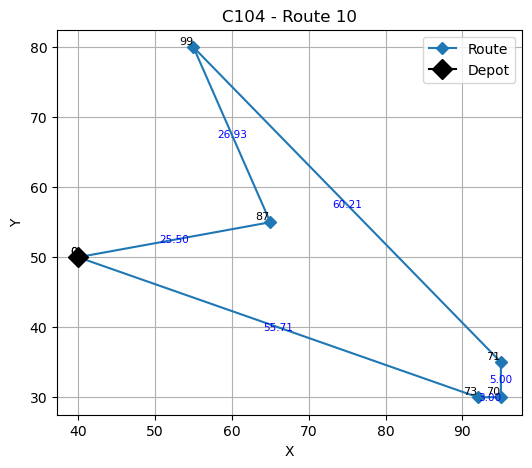

Route 11: [0, 13, 15, 100, 33, 59, 57, 0]
Truck capacity: 180.0
Total distance travelled: 213
Starting time: 0h31
Ending time: 19h08



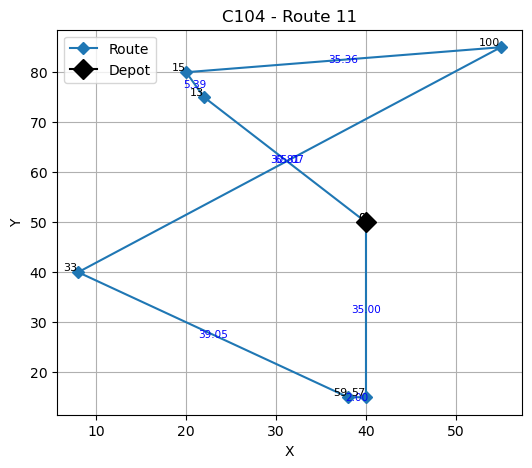

Route 12: [0, 54, 56, 60, 80, 0]
Truck capacity: 100.0
Total distance travelled: 156
Starting time: 7h59
Ending time: 16h35



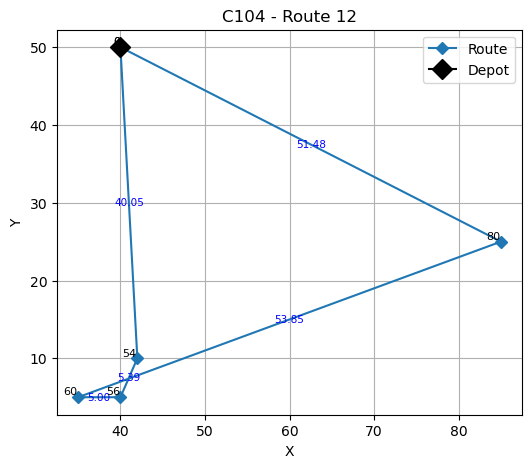

Route 13: [0, 38, 79, 0]
Truck capacity: 40.0
Total distance travelled: 180
Starting time: 7h59
Ending time: 13h59



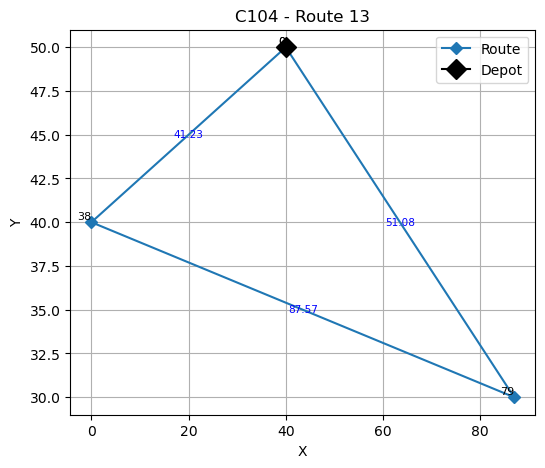

Route 14: [0, 92, 77, 0]
Truck capacity: 30.0
Total distance travelled: 156
Starting time: 4h46
Ending time: 11h56



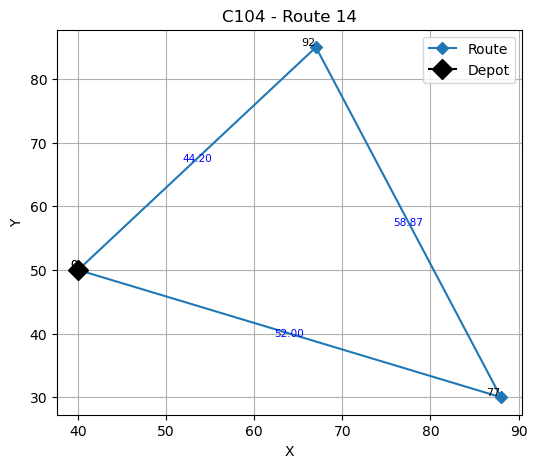

Route 15: [0, 58, 0]
Truck capacity: 30.0
Total distance travelled: 91
Starting time: 4h46
Ending time: 10h06



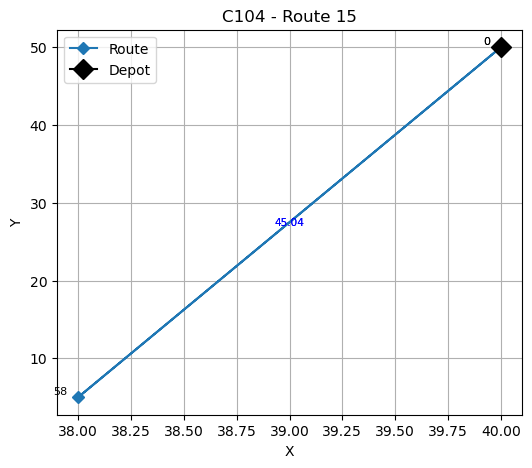

Route 16: [0, 53, 0]
Truck capacity: 20.0
Total distance travelled: 91
Starting time: 4h46
Ending time: 7h46



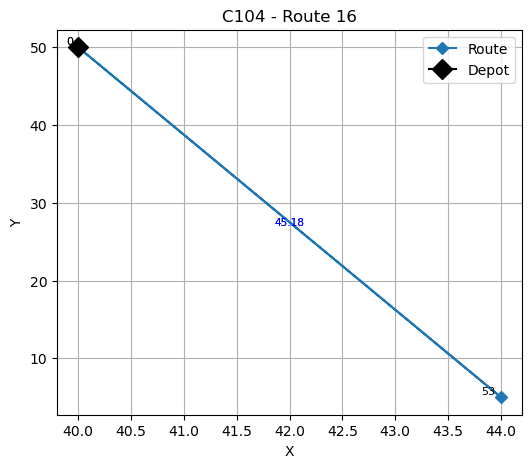

Route 17: [0, 55, 0]
Truck capacity: 10.0
Total distance travelled: 71
Starting time: 1h35
Ending time: 4h15



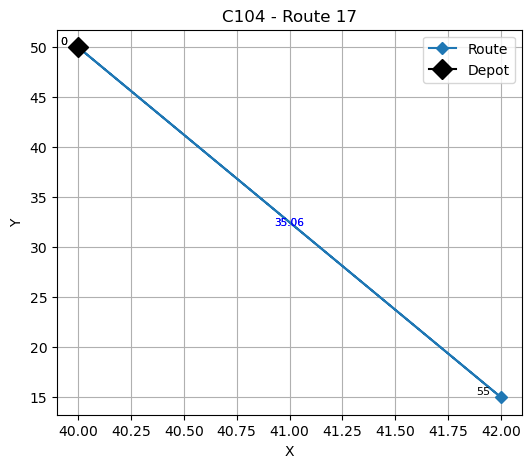

Route 18: [0, 76, 0]
Truck capacity: 10.0
Total distance travelled: 105
Starting time: 3h23
Ending time: 6h37



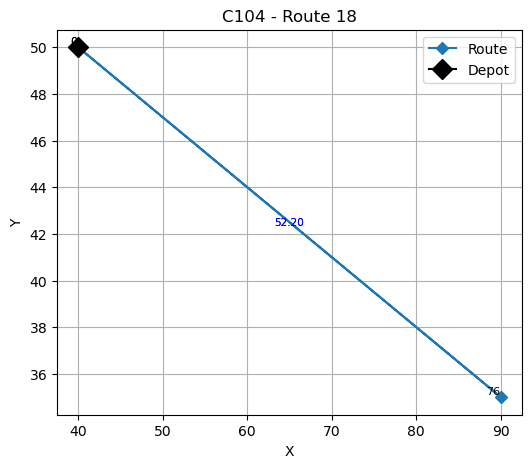

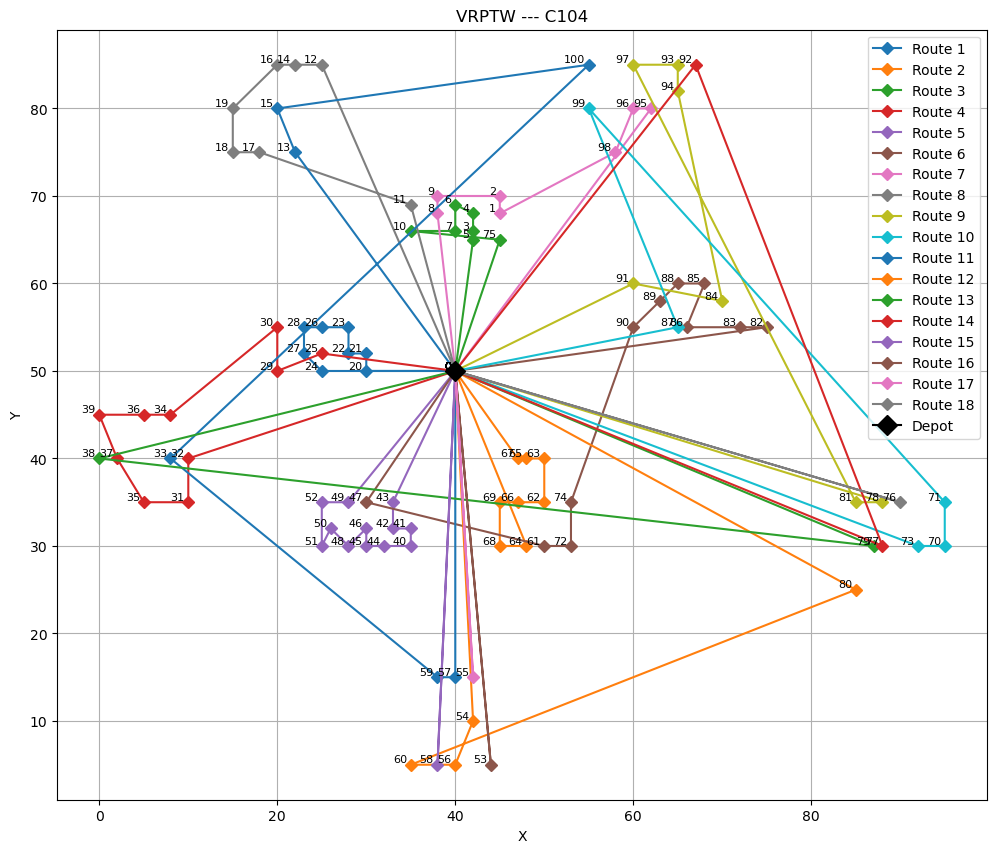

In [ ]:
# used ressource :
# https://medium.com/@writingforara/solving-vehicle-routing-problems-with-python-heuristics-algorithm-2cc57fe7079c

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import random

def read_excel_file(file_path, sheet_name):
    """
    Read coordinates and demand values from a specific sheet in an Excel file.
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    coordinates = df[['X', 'Y']].values
    demands = df['Demand'].values
    return coordinates, demands

def read_txt_file(file_path):
    """
    Reads a VRP text file and extracts vehicle and customer informations.
    """
    with open(file_path, 'r') as file:      # Read data
        lines = file.readlines()            # Split data into line
    vehicle_info = lines[4].split()         # Informations about vehicles are on line 5 for Solomon instance (index 4)
    vehicle_number = vehicle_info[0]        # Number of vehicle available
    vehicle_capacity = vehicle_info[1]      # Maximun capacity allowed in vehicle
    customer_data_start = lines.index("CUSTOMER\n") + 3  # Informations about customers start 3 lines after the index of the word "CUSTOMER"
    customer_lines = lines[customer_data_start:]
    
    coordinates = []
    demands = []
    ready_times = []
    due_times = []
    service_times = []
    
    for line in customer_lines:
        if line.strip():  # Skip empty lines
            values = list(map(float, line.split()))
            coordinates.append((values[1], values[2]))
            demands.append(values[3]) 
            ready_times.append(values[4])  
            due_times.append(values[5])  
            service_times.append(values[6]) 
    
    return vehicle_number, vehicle_capacity, coordinates, demands, ready_times, due_times, service_times
   
def adjacency_matrix(coordinates):
    """
    Calculate the adjacency matrix.
    """
    num_points = len(coordinates)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            adj_matrix[i, j] = calculate_distance(coordinates, i, j)
    return adj_matrix

def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calculate_total_distance(route, adj_matrix):
    """
    Calculate the total distance of a given route using the distance matrix.
    """
    total_distance = 0
    num_points = len(route)
    for i in range(num_points - 1):
        current_node = route[i]
        next_node = route[i + 1]
        total_distance += adj_matrix[current_node, next_node]
    return total_distance

def nearest_neighbor_with_time_windows(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time):
    """
    Nearest Neighbor heuristic with time windows.
    Takes into account start_time and ensures end_time never exceeds depot's closing time (latest_time[0]).
    """
    num_points = adj_matrix.shape[0]
    visited = [False] * num_points
    routes = []
    capacity_list = []
    time_list = []
    start_list = []

    while sum(visited) < num_points:
        current_node = 0  # Start from the depot
        current_capacity = 0
        current_time = 0  # Cumulative time for the route
        route = [current_node]
        visited[current_node] = True

        # Determine the earliest possible start time for this route
        next_client = None
        for i in range(1, num_points):
            if not visited[i]:
                next_client = i
                break

        # Set the route start time
        if next_client is not None:
            start_time = max(earliest_time[next_client], earliest_time[0] + adj_matrix[0, next_client])
        else:
            start_time = earliest_time[0]

        while True:
            last_node = route[-1]
            nearest = None
            min_distance = float('inf')

            # Find the nearest unvisited neighbor within constraints
            for neighbor in [i for i, v in enumerate(visited) if not v]:
                travel_time = adj_matrix[last_node, neighbor]
                arrival_time = start_time + current_time + travel_time

                # Check capacity and time window constraints
                if (demands[neighbor] + current_capacity <= capacity_max
                        and arrival_time <= latest_time[neighbor]
                        and adj_matrix[last_node, neighbor] < min_distance):
                    nearest = neighbor
                    min_distance = adj_matrix[last_node, neighbor]

            if nearest is None:
                break  # No valid neighbor to add

            # Update route, time, and capacity
            travel_time = adj_matrix[last_node, nearest]
            current_time += travel_time
            current_time = max(current_time, earliest_time[nearest] - start_time)  # Wait if arriving early
            current_time += service_time[nearest]
            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

            # Check if the return to the depot exceeds latest_time[0]
            return_to_depot_time = adj_matrix[nearest, 0]
            end_time = start_time + current_time + return_to_depot_time
            if end_time > latest_time[0]:
                # End the current route
                route.append(0)  # Return to depot
                routes.append(route)
                capacity_list.append(current_capacity)
                time_list.append(current_time)
                start_list.append(start_time)

                # Start a new route
                current_node = 0
                current_capacity = 0
                current_time = 0
                route = [current_node]
                break

        # End the current route and return to the depot
        return_to_depot_time = adj_matrix[route[-1], 0]
        route.append(0)
        end_time = start_time + current_time + return_to_depot_time
        if end_time <= latest_time[0]:
            routes.append(route)
            capacity_list.append(current_capacity)
            time_list.append(current_time + return_to_depot_time)
            start_list.append(start_time)

    return routes, capacity_list, time_list, start_list

def format_output(routes):
    """
    Format the final routes as required.
    """
    routes = [[int(node) for node in route] for route in routes]
    return routes

def convert_time(time):
    """
    Format time (XhXX).
    """
    minutes, secondes = divmod(round(time), 60) 
    return f"{minutes}h{secondes:02d}"

def plot_global_routes(coordinates, solution, title, size):
    """
    Displays all routes in a single plot.
    """
    coordinates = np.array(coordinates)
    xcoor, ycoor= coordinates[0]
    plt.figure(figsize=(1.2 * size, size))    
    for index, route in enumerate(solution):
        route_coordinates = coordinates[route]
        plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], 
                 marker='D', linestyle="solid", label=f"Route {index + 1}")
        for i, (x, y) in enumerate(route_coordinates):
            plt.text(x - 0.04 * size, y, str(route[i]), fontsize=8, ha="right", va='bottom')
    plt.plot([xcoor], [ycoor], marker='D', ms= size, color='black', label="Depot")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("VRPTW --- " + title.upper())
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
def plot_route_with_distances(coordinates, route, title, size=5):
    """
    Displays a single route with distances annotated on each edge and arrows indicating the direction of travel.
    """
    coordinates = np.array(coordinates)
    xcoor, ycoor= coordinates[0]
    plt.figure(figsize=(1.2 * size, size))    
    route_coordinates = coordinates[route]
    plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], 
             marker='D', linestyle="solid", label="Route")
    
    # Annotate each edge with the distance
    for i in range(len(route) - 1):
        x1, y1 = route_coordinates[i]
        x2, y2 = route_coordinates[i + 1]
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2  # Midpoint for annotation
        plt.text(mid_x, mid_y, f"{distance:.2f}", color='blue', fontsize=1.5*size, ha="center", va="center")

    for i, (x, y) in enumerate(route_coordinates):
        plt.text(x - 0.01 * size, y + 0.01 * size, str(route[i]), fontsize=8, ha="right", va='bottom')
        
    plt.plot([xcoor], [ycoor], marker='D', ms=2 * size, color='black', label="Depot")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def vrp_solver(location):
    """
    Solve the VRP with time windows using the provided location for coordinates and constraints.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times, start_list = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in all_routes]
    all_routes = format_output(all_routes)
    total_distance = sum(calculate_total_distance(route, adj_matrix) for route in all_routes)
    return all_routes, capacity_list, route_distances, route_times, coordinates, start_list, total_distance, earliest_time, latest_time



folder = "..\\Dataset\\" 
dataset_name = "c104"
location = folder + dataset_name + ".txt"
solution, capacity_list, route_distances, route_times, coordinates, start_list, total_distance, earliest_time, latest_time = vrp_solver(location)

n = 0
print("Depot opening hours: " + str(convert_time(earliest_time[0])) + "-" + str(convert_time(latest_time[0])))
print("Total distance: " + str(ceil(total_distance)))
print("Number of routes: " + str(len(solution)) + "\n")

for route, distance, route_time, start in zip(solution, route_distances, route_times, start_list):
    end_time = start + route_time
    print(f"Route {n+1}: {route}\n"
    f"Truck capacity: {capacity_list[n]}\n"
    f"Total distance travelled: {ceil(distance)}\n"
    f"Starting time: {convert_time(start)}\n"
    f"Ending time: {convert_time(end_time)}\n"
    )

    plot_route_with_distances(coordinates, route, f"{dataset_name.upper()} - Route {n+1}", 5)
    n += 1
    
plot_global_routes(coordinates, solution, dataset_name, 10)

### Two-Opt Algorithm and SA Algorithm (Seperated)


In [17]:
# Use two opt
def two_opt(routes, adj_matrix, num_iterations):
    """
    Enhanced Two-Opt heuristic for route optimization with time constraints.
    """
    best_routes = routes.copy()
    best_distance = sum(calculate_total_distance(route, adj_matrix) for route in best_routes)

    for _ in range(num_iterations):
        # Select a random route
        selected_route_index = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_index]

        # Randomly pick two indices
        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        # Create a new route by reversing segment i to j
        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1:i - 1:-1]

        # Validate the route with time windows
        new_routes = routes.copy()
        new_routes[selected_route_index] = new_route

            # Calculate the cost for the new solution
        new_cost = sum(calculate_total_distance(route, adj_matrix) for route in new_routes)
        if new_cost < best_distance:
            best_routes = new_routes
            best_distance = new_cost

    return best_routes

def simulated_annealing(routes, adj_matrix, num_iterations, temperature):
    best_routes = routes.copy()
    current_routes = routes.copy()
    best_distance = sum(calculate_total_distance(route, adj_matrix) for route in best_routes)

    for _ in range(num_iterations):
        temp = max(0.01, temperature * (1 - (_ / num_iterations)))  # Cool down

        # Random perturbation
        selected_route_index = np.random.randint(0, len(current_routes))
        i, j = np.random.randint(1, len(current_routes[selected_route_index]) - 1, size=2)
        if j < i: i, j = j, i
        perturbed_route = current_routes[selected_route_index].copy()
        perturbed_route[i:j] = current_routes[selected_route_index][j - 1:i - 1:-1]

        # Cost calculation
        perturbed_routes = current_routes.copy()
        perturbed_routes[selected_route_index] = perturbed_route
        perturbed_cost = sum(calculate_total_distance(route, adj_matrix) for route in perturbed_routes)

        # Accept or reject
        if (perturbed_cost < best_distance or
            np.random.rand() < np.exp((best_distance - perturbed_cost) / temp)):
            current_routes = perturbed_routes
            if perturbed_cost < best_distance:
                best_routes = perturbed_routes
                best_distance = perturbed_cost

    return best_routes



def vrp_solver2(location, num_iterations):
    """
    Solve the VRP using the provided location for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times, start_list = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    optimized_routes = two_opt(all_routes, adj_matrix, num_iterations)
    #optimized_routes = simulated_annealing(all_routes, adj_matrix, num_iterations, 2000)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in optimized_routes]
    formatted_routes = format_output(optimized_routes)
    return formatted_routes, route_distances, capacity_list, route_times, coordinates, start_list

# Main execution
num_iterations = 100000
solution, route_distances, capacity_list, route_times, coordinates, start_list = vrp_solver2(location, num_iterations)

# Display results
n = 0
print("Total cost: " + str(ceil(cost)))
for route, distance, route_time, start in zip(solution, route_distances, route_times, start_list):
    end = convert_time(start + route_time)
    print(f"Route {n+1}: {route}\n"
          f"Truck capacity: {capacity_list[n]}\n"
          f"Total distance travelled (cost): {ceil(distance)}\n"
          f"Starting time: {convert_time(start)}\n"
          f"Ending time: {end}\n"          
          f"Total time: {convert_time(route_time)}\n"
          )
    plot_route_with_distances(coordinates, route, f"{dataset_name.upper()} - Route {n+1}", 5)
    n += 1
    
plot_global_routes(coordinates, solution, dataset_name, 10)


NameError: name 'cost' is not defined

### Tabu list

In [ ]:
# --- Correction de la fonction de nearest_neighbor_with_time_windows ---
def nearest_neighbor_with_time_windows(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time):
    """
    Nearest Neighbor heuristic with time windows.
    """
    num_points = adj_matrix.shape[0]  # Count rows in matrix to get the number of points
    visited = [False] * num_points  # Boolean array to inform if a point was visited or not
    routes = []  # Array to store multiple routes
    capacity_list = []  # Array storing the final capacity of each route
    time_list = []  # Array keeping total time needed for each route in mind
    start_list = []  # Array storing starting time of one travel

    while sum(visited) < num_points:  # While all points are not visited
        current_node = 0  # Start at the depot
        current_capacity = 0  # Initialize empty capacity
        current_time = earliest_time[current_node]  # Initialize current_time to the READY TIME of the depot (often 0)
        route = [current_node]  # Array storing the current route starting with the depot
        visited[current_node] = True  # Mark depot as visited

        while True:
            last_node = route[-1]  # last_node is the last element in route
            nearest = None  # nearest corresponds to the next nearest neighbor (which is unknown here)
            min_distance = float('inf')  # Initialize min_distance to infinity

            for neighbor in [i for i, v in enumerate(visited) if not v]:
                travel_time = adj_matrix[last_node, neighbor]  # Time = distance (simplification)
                arrival_time = current_time + travel_time  # Calculate the arrival time

                if (demands[neighbor] + current_capacity <= capacity_max  # Capacity is not exceeded
                        and arrival_time <= latest_time[neighbor]  # Arrival within the latest time window
                        and arrival_time >= earliest_time[neighbor]  # Arrival after the earliest time
                        and adj_matrix[last_node, neighbor] < min_distance):  # Find nearest neighbor
                    nearest = neighbor
                    min_distance = adj_matrix[last_node, neighbor]

            if nearest is None:  # No more valid neighbors, end this route
                break

            # Update route, time, and capacity
            travel_time = adj_matrix[last_node, nearest]
            current_time += travel_time
            current_time = max(current_time, earliest_time[nearest])  # Wait if arriving early
            current_time += service_time[nearest]  # Add service time
            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

        # Return to depot
        travel_time = adj_matrix[route[-1], 0]  # Travel time between last node and the depot
        current_time += travel_time
        route.append(0)  # End the route at the depot

        routes.append(route)  # Add the route to all routes
        capacity_list.append(current_capacity)  # Add the current capacity to the capacity list
        time_list.append(current_time)  # Add the current time to the time list
        start_list.append(max(0, earliest_time[route[1]] - adj_matrix[route[0], route[1]]))  # Calculate start time

    return routes, capacity_list, time_list, start_list


# --- Fonction d'évaluation ---
def evaluate_solution(routes, adj_matrix):
    """
    Calculate the total distance cost of a given solution (sum of the distances of all routes).
    """
    total_dist = 0
    for route in routes:
        total_dist += calculate_total_distance(route, adj_matrix)
    return total_dist


# --- Tabu Search ---
def swap_customers(route1, route2):
    """
    Swap two customers between two routes.
    """
    i = random.randint(1, len(route1) - 1)  # Exclude depot (index 0)
    j = random.randint(1, len(route2) - 1)  # Exclude depot (index 0)
    route1_new = route1[:]
    route2_new = route2[:]
    route1_new[i], route2_new[j] = route2_new[j], route1_new[i]
    return route1_new, route2_new


def tabu_search(initial_routes, adj_matrix, max_iter=100, tabu_tenure=10):
    """
    Perform Tabu Search to improve the initial solution.
    """
    current_solution = initial_routes
    best_solution = current_solution
    best_distance = evaluate_solution(current_solution, adj_matrix)
    tabu_list = []  # Tabu list to store recent changes

    # Perform Tabu Search for a fixed number of iterations
    for iteration in range(max_iter):
        neighbors = []
        for i in range(len(current_solution)):
            for j in range(i + 1, len(current_solution)):
                route1, route2 = swap_customers(current_solution[i], current_solution[j])
                neighbors.append((route1, route2))

        # Evaluate neighbors
        best_neighbor = None
        best_neighbor_cost = float('inf')

        for neighbor in neighbors:
            if neighbor not in tabu_list:  # Check if neighbor is not in tabu list
                neighbor_cost = evaluate_solution(neighbor, adj_matrix)
                if neighbor_cost < best_neighbor_cost:
                    best_neighbor = neighbor
                    best_neighbor_cost = neighbor_cost

        # Update the solution
        if best_neighbor_cost < best_distance:
            best_solution = best_neighbor
            best_distance = best_neighbor_cost

        # Update Tabu List
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)  # Remove the oldest tabu entry

        print(f"Iteration {iteration + 1}/{max_iter}, Best Cost: {best_distance}")

    return best_solution, best_distance


# --- Main Solver with Tabu Search ---
def vrp_solver_with_tabu(location, max_iter=100, tabu_tenure=10):
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    initial_routes, capacity_list, route_distances, route_times, start_list = nearest_neighbor_with_time_windows(
        adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time
    )

    # Améliorer la solution en utilisant Tabu Search
    optimized_routes, optimized_cost = tabu_search(initial_routes, adj_matrix, max_iter, tabu_tenure)

    # Afficher la solution optimisée
    print("Optimized Total Cost: ", ceil(optimized_cost))
    return optimized_routes, optimized_cost

optimized_solution, optimized_cost = vrp_solver_with_tabu(location)


KeyboardInterrupt: 

### Colonie

Depot opening hours: 0h00-20h36
Total distance: 261294
Number of routes: 11

Route 1: [0, 21, 22, 23, 26, 28, 30, 29, 0]
Truck capacity used: 100.0
Total distance travelled: 49
Starting time: 0h00
Ending time: 20h15

Route 2: [0, 20, 24, 27, 32, 33, 35, 37, 36, 34, 39, 31, 0]
Truck capacity used: 200.0
Total distance travelled: 114
Starting time: 0h00
Ending time: 18h24

Route 3: [0, 67, 65, 63, 62, 74, 61, 64, 68, 66, 69, 72, 0]
Truck capacity used: 200.0
Total distance travelled: 75
Starting time: 0h12
Ending time: 19h01

Route 4: [0, 91, 89, 90, 92, 93, 97, 100, 99, 14, 16, 0]
Truck capacity used: 200.0
Total distance travelled: 154
Starting time: 0h00
Ending time: 18h11

Route 5: [0, 87, 86, 88, 85, 84, 83, 82, 78, 81, 73, 0]
Truck capacity used: 200.0
Total distance travelled: 136
Starting time: 1h25
Ending time: 19h41

Route 6: [0, 7, 8, 10, 11, 9, 6, 4, 3, 5, 75, 1, 0]
Truck capacity used: 150.0
Total distance travelled: 61
Starting time: 0h00
Ending time: 20h05

Route 7: [0, 25

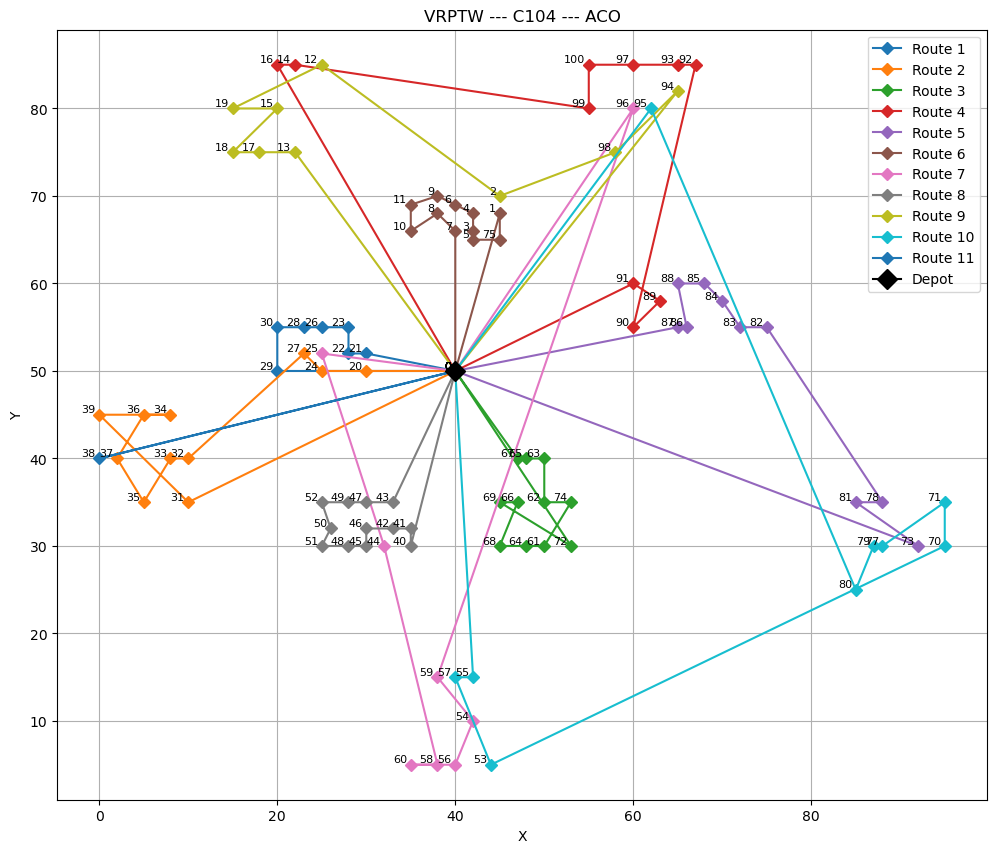

In [36]:
import numpy as np
import random
from math import ceil

def aco_vrp(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time, num_ants, num_iterations, alpha=1.5, beta=2.5, evaporation_rate=0.5, q=100):
    num_points = adj_matrix.shape[0]
    ph_matrix = np.ones((num_points, num_points))  # Initial pheromone matrix
    best_solution = None
    best_distance = float('inf')

    # Calcul des probabilités de transition entre les nœuds
    def calculate_probabilities(current_node, unvisited, current_time, current_capacity):
        attractiveness = []
        for neighbor in unvisited:
            travel_time = adj_matrix[current_node, neighbor]
            arrival_time = current_time + travel_time
            return_to_depot_time = adj_matrix[neighbor, 0]
            if (demands[neighbor] + current_capacity <= capacity_max and 
                arrival_time <= latest_time[neighbor] and 
                arrival_time + service_time[neighbor] + return_to_depot_time <= latest_time[0]):
                tau = ph_matrix[current_node, neighbor] ** alpha
                eta = (1.0 / adj_matrix[current_node, neighbor]) ** beta
                attractiveness.append(tau * eta)
            else:
                attractiveness.append(0)
        
        total = sum(attractiveness)
        if total == 0:
            return np.zeros(len(unvisited))  # Avoid division by zero
        return np.array(attractiveness) / total

    # Fonction de construction de la solution
    def construct_solution():
        visited = [False] * num_points
        routes = []
        route_times = []  
        route_capacities = []  

        while sum(visited) < num_points - 1:  
            current_node = 0
            current_time = earliest_time[current_node]
            current_capacity = 0
            route = [current_node]
            visited[current_node] = True

            while True:
                unvisited = [i for i in range(num_points) if not visited[i]]
                if not unvisited:
                    break
                
                probabilities = calculate_probabilities(current_node, unvisited, current_time, current_capacity)
                if not probabilities.any():
                    break  # Aucune transition valide
                
                next_node = random.choices(unvisited, weights=probabilities)[0]

                # Calcul du temps de trajet et mise à jour du temps et de la capacité
                travel_time = adj_matrix[current_node, next_node]
                arrival_time = current_time + travel_time

                # Anticipation du retour au dépôt
                return_to_depot_time = adj_matrix[next_node, 0]
                if (arrival_time > latest_time[next_node] or 
                   arrival_time + service_time[next_node] + return_to_depot_time > latest_time[0]):
                    probabilities[unvisited.index(next_node)] = 0
                    probabilities /= probabilities.sum() if probabilities.sum() > 0 else 1
                    continue  # Recalculer avec les probabilités mises à jour

                # Mise à jour de l'état
                current_time = max(arrival_time, earliest_time[next_node]) + service_time[next_node]
                current_capacity += demands[next_node]
                route.append(next_node)
                visited[next_node] = True
                current_node = next_node

            # Vérification du retour au dépôt
            return_to_depot_time = adj_matrix[current_node, 0]
            if current_time + return_to_depot_time > latest_time[0]:
                continue  # Ignorer cette route si le retour au dépôt est trop tard

            # Ajouter le retour au dépôt
            route.append(0)
            current_time += return_to_depot_time

            # Stocker les détails de la route
            routes.append(route)
            route_times.append(current_time)
            route_capacities.append(current_capacity)

        return routes, route_times, route_capacities

    # Fonction d'évaluation des solutions avec pénalités
    def calculate_distance_with_penalties(routes):
        total_dist = 0
        num_vehicles = len(routes)
        total_dist += 10000 * num_vehicles  # Pénalité pour un nombre trop élevé de véhicules
        for route in routes:
            total_dist += calculate_total_distance(route, adj_matrix)

            # Vérification des violations temporelles
            current_time = earliest_time[0]
            for i in range(len(route) - 1):
                current_node, next_node = route[i], route[i + 1]
                travel_time = adj_matrix[current_node, next_node]
                current_time = max(current_time + travel_time, earliest_time[next_node]) + service_time[next_node]
                if current_time > latest_time[next_node]:
                    total_dist += 10000  # Pénalité pour violation des fenêtres temporelles

            # Vérification du retour au dépôt
            return_to_depot_time = adj_matrix[route[-2], 0]
            if current_time + return_to_depot_time > latest_time[0]:
                total_dist += 10000  # Pénalité pour retour trop tardif
        return total_dist

    # Fonction de mise à jour des phéromones
    def update_pheromones(routes, cost):
        for route in routes:
            for i in range(len(route) - 1):
                ph_matrix[route[i], route[i + 1]] += q / cost
        ph_matrix[:] *= (1 - evaporation_rate)  # Evaporation des phéromones

    # Main ACO loop
    for iteration in range(num_iterations):
        all_solutions = []
        all_costs = []
        for _ in range(num_ants):
            solution, route_times, route_capacities = construct_solution()
            cost = calculate_distance_with_penalties(solution)
            all_solutions.append((solution, route_times, route_capacities))
            all_costs.append(cost)
            if cost < best_distance:
                best_distance = cost
                best_solution = (solution, route_times, route_capacities)
        best_iteration_cost = min(all_costs)
        best_iteration_solution = all_solutions[np.argmin(all_costs)][0]
        update_pheromones(best_iteration_solution, best_iteration_cost)

    return best_solution, best_distance

# Initialisation des données VRP
def initialize_vrp_data(location):
    nb_vehicle, capacity_max, coordinates, demands, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    return adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time, coordinates

# Charger les données nécessaires pour ACO
adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time, coordinates = initialize_vrp_data(location)

# Lancer l'algorithme ACO
best_solution_data, best_distance = aco_vrp(
    adj_matrix, demands, int(capacity_max), earliest_time, latest_time, service_time,
    num_ants=100, num_iterations=150, alpha=1.5, beta=5, evaporation_rate=0.5, q=100
)

best_solution, route_times, route_capacities = best_solution_data
best_solution = [[int(node) for node in route] for route in best_solution]
route_distances = [calculate_total_distance(route, adj_matrix) for route in best_solution]
best_distance = best_distance - 10000 * len(best_solution)

print("Depot opening hours: " + str(convert_time(earliest_time[0])) + "-" + str(convert_time(latest_time[0])))
print(f"Total distance: {ceil(best_distance)}")
print(f"Number of routes: {len(best_solution)}\n")

n = 0
for route, distance, route_time, capacity in zip(best_solution, route_distances, route_times, route_capacities):
    start_time = earliest_time[route[1]]
    end_time = convert_time(route_time + start_time)
    print(f"Route {n + 1}: {route}")
    print(f"Truck capacity used: {capacity}")
    print(f"Total distance travelled: {ceil(distance)}")
    print(f"Starting time: {convert_time(start_time)}")
    print(f"Ending time: {end_time}\n")
    n += 1

# Visualisation globale des routes
plot_global_routes(coordinates, best_solution, dataset_name + " --- ACO", size=10)



Depot opening hours: 0h00-3h50
Total distance: 172121
Number of routes: 28

Route 1: [0, 69, 79, 3, 68, 77, 0]
Truck capacity used: 92.0
Total distance travelled: 67
Starting time: 0h50
Ending time: 4h19

Route 2: [0, 45, 61, 85, 97, 91, 100, 0]
Truck capacity used: 100.0
Total distance travelled: 96
Starting time: 0h32
Ending time: 4h11

Route 3: [0, 21, 73, 22, 55, 24, 80, 0]
Truck capacity used: 49.0
Total distance travelled: 93
Starting time: 1h02
Ending time: 4h35

Route 4: [0, 53, 58, 0]
Truck capacity used: 32.0
Total distance travelled: 19
Starting time: 1h35
Ending time: 5h14

Route 5: [0, 30, 9, 35, 70, 0]
Truck capacity used: 50.0
Total distance travelled: 99
Starting time: 1h11
Ending time: 4h44

Route 6: [0, 40, 54, 25, 0]
Truck capacity used: 33.0
Total distance travelled: 75
Starting time: 1h25
Ending time: 5h01

Route 7: [0, 63, 11, 90, 32, 0]
Truck capacity used: 48.0
Total distance travelled: 93
Starting time: 0h34
Ending time: 3h39

Route 8: [0, 76, 50, 1, 0]
Truck c

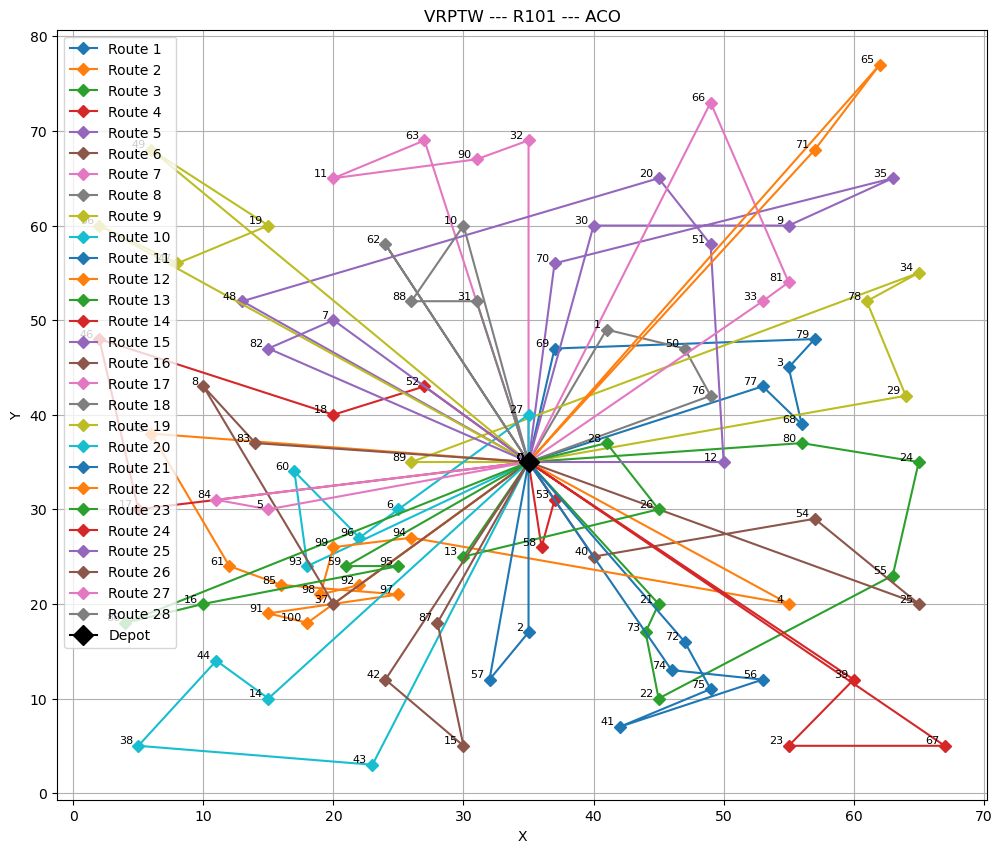

In [ ]:
def aco_vrp_with_start_time_and_constraints(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time, num_ants, num_iterations, alpha=1.5, beta=2.5, evaporation_rate=0.5, q=100):
    num_points = adj_matrix.shape[0]
    ph_matrix = np.ones((num_points, num_points))  # Initial pheromone matrix
    best_solution = None
    best_distance = float('inf')

    def calculate_probabilities(current_node, unvisited, current_time, current_capacity, start_time):
        """
        Calculate the probabilities of transitioning to the next node while respecting constraints.
        """
        attractiveness = []
        for neighbor in unvisited:
            travel_time = adj_matrix[current_node, neighbor]
            arrival_time = current_time + travel_time
            return_to_depot_time = adj_matrix[neighbor, 0]

            # Check constraints: capacity, time window, and depot closing time
            end_time = arrival_time + service_time[neighbor] + return_to_depot_time
            if (demands[neighbor] + current_capacity <= capacity_max and 
                arrival_time <= latest_time[neighbor] and 
                end_time <= latest_time[0]):
                tau = ph_matrix[current_node, neighbor] ** alpha
                eta = (1.0 / adj_matrix[current_node, neighbor]) ** beta
                attractiveness.append(tau * eta)
            else:
                attractiveness.append(0)

        total = sum(attractiveness)
        if total == 0:
            return np.zeros(len(unvisited))
        return np.array(attractiveness) / total

    def construct_solution():
        """
        Construct a solution respecting time window constraints and start times.
        """
        visited = [False] * num_points
        routes = []
        route_times = []
        route_capacities = []

        while sum(visited) < num_points - 1:  
            current_node = 0
            current_capacity = 0
            current_time = earliest_time[current_node]
            route = [current_node]
            visited[current_node] = True

            # Start time for this route
            start_time = current_time  

            while True:
                unvisited = [i for i in range(1, num_points) if not visited[i]]
                if not unvisited:
                    break

                probabilities = calculate_probabilities(current_node, unvisited, current_time, current_capacity, start_time)
                if not probabilities.any():
                    break  # No valid transitions

                next_node = random.choices(unvisited, weights=probabilities)[0]

                # Check constraints before committing to this node
                travel_time = adj_matrix[current_node, next_node]
                arrival_time = current_time + travel_time
                return_to_depot_time = adj_matrix[next_node, 0]
                end_time = arrival_time + service_time[next_node] + return_to_depot_time

                if end_time > latest_time[0]:
                    break  # Cannot continue, depot closing time violated

                # Update state
                current_time = max(arrival_time, earliest_time[next_node]) + service_time[next_node]
                current_capacity += demands[next_node]
                route.append(next_node)
                visited[next_node] = True
                current_node = next_node

            # Add return-to-depot
            return_to_depot_time = adj_matrix[current_node, 0]
            current_time += return_to_depot_time
            route.append(0)

            # Store route details
            routes.append(route)
            route_times.append(current_time)
            route_capacities.append(current_capacity)

        return routes, route_times, route_capacities

    def calculate_distance_with_penalties(routes):
        """
        Evaluate the solution and apply penalties for constraint violations.
        """
        total_dist = 0
        num_vehicles = len(routes)
        total_dist += 10000 * num_vehicles  # Penalty for extra vehicles

        for route in routes:
            total_dist += calculate_total_distance(route, adj_matrix)
            current_time = earliest_time[0]

            for i in range(len(route) - 1):
                current_node, next_node = route[i], route[i + 1]
                travel_time = adj_matrix[current_node, next_node]
                current_time = max(current_time + travel_time, earliest_time[next_node]) + service_time[next_node]
                if current_time > latest_time[next_node]:
                    total_dist += 10000  # Penalty for time window violations

            # Check depot closing time
            return_to_depot_time = adj_matrix[route[-2], 0]
            if current_time + return_to_depot_time > latest_time[0]:
                total_dist += 10000  # Penalty for late return
        return total_dist

    def update_pheromones(routes, cost):
        """
        Update pheromones on the edges used in the routes.
        """
        for route in routes:
            for i in range(len(route) - 1):
                ph_matrix[route[i], route[i + 1]] += q / cost
        ph_matrix[:] *= (1 - evaporation_rate)

    for iteration in range(num_iterations):
        all_solutions = []
        all_costs = []

        for _ in range(num_ants):
            solution, route_times, route_capacities = construct_solution()
            cost = calculate_distance_with_penalties(solution)
            all_solutions.append((solution, route_times, route_capacities))
            all_costs.append(cost)
            if cost < best_distance:
                best_distance = cost
                best_solution = (solution, route_times, route_capacities)

        best_iteration_cost = min(all_costs)
        best_iteration_solution = all_solutions[np.argmin(all_costs)][0]
        update_pheromones(best_iteration_solution, best_iteration_cost)

    return best_solution, best_distance




# Initialisation des données VRP
def initialize_vrp_data(location):
    nb_vehicle, capacity_max, coordinates, demands, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    return adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time, coordinates

# Charger les données nécessaires pour ACO
adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time, coordinates = initialize_vrp_data(location)

# Lancer l'algorithme ACO
best_solution_data, best_distance = aco_vrp(
    adj_matrix, demands, int(capacity_max), earliest_time, latest_time, service_time,
    num_ants=100, num_iterations=150, alpha=1.5, beta=2, evaporation_rate=0.5, q=100
)

best_solution, route_times, route_capacities = best_solution_data
best_solution = [[int(node) for node in route] for route in best_solution]
route_distances = [calculate_total_distance(route, adj_matrix) for route in best_solution]
best_distance = best_distance - 10000 * len(best_solution)

print("Depot opening hours: " + str(convert_time(earliest_time[0])) + "-" + str(convert_time(latest_time[0])))
print(f"Total distance: {ceil(best_distance)}")
print(f"Number of routes: {len(best_solution)}\n")

n = 0
for route, distance, route_time, capacity in zip(best_solution, route_distances, route_times, route_capacities):
    start_time = earliest_time[route[1]]
    end_time = convert_time(route_time + start_time)
    print(f"Route {n + 1}: {route}")
    print(f"Truck capacity used: {capacity}")
    print(f"Total distance travelled: {ceil(distance)}")
    print(f"Starting time: {convert_time(start_time)}")
    print(f"Ending time: {end_time}\n")
    n += 1

# Visualisation globale des routes
plot_global_routes(coordinates, best_solution, dataset_name + " --- ACO", size=10)

